In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

# Data sets used 

All of the various mRS probability data sets are gathered here for time=0 and time=$T_0$, i.e. no effect time.

Any data sets containing mRS=6 (death) have the associated probability $P(mRS=6)$ removed, and the remaining values are normalised so that $P(mRS\leq5)=1.0$.

+ nLVO - non-large-vessel occlusion
+ LVO - large-vessel occlusion

Arrays are named using these strings:
+ `dist` - mRS distribution
+ `bins` - cumulative probabilities of `dist`
+ `0` and `F` - time $t=0$hr and $t=T_0$hr.

Plus more specific labels are appended. 

mRS distribution arrays used here:

| Description | $t=0$ | $t=T_0$ | 
| :-- | :-- | :-- |
| Pre-stroke | `dist_0_pre` <br /> From SAMueL-1 data. | N/A |
|Haemorrhaegic | N/A | (yet to find) |
| nLVO - untreated | N/A | `dist_F_nLVO` <br /> Weighted combination of `dist_F_Lees` (64%) and `dist_F_LVO` (36%), then further scaled to match $P(mRS<=1, t=T_0)=0.46$ from Holodinsky+2018. |
| nLVO - thrombolysis | `dist_0_nLVOoly` <br /> Weighted combination of `dist_0_pre` (87%) and `dist_F_nLVO` (13%), where weights are chosen to match the $P(mRS<=1, t=0)=0.63$ from Holodinsky+2018. | Same as above. |
| LVO - untreated | N/A | `dist_F_LVO` <br /> Goyal+2016 control population. |
| LVO - thrombolysis only | `dist_0_LVOoly` <br /> Weighted combination of `dist_F_LVO` (82%) and `dist_0_pre` (18%). | Same as above. |
| LVO - thrombectomy <br /> with/out thrombolysis | `dist_0_LVOect` <br /> No effect of stroke, therefore same mRS as pre-stroke. | Same as above. | 

Also, 

| Array | Time $t$ | Description | Data sources |
| :--- | :---: | :--- | :--- |
| `dist_F_Lees`    | $T_0$ | Untreated LVO and nLVO populations. | Lees+2010. |


---

# Pre-stroke

Plot the distribution of mRS at time T=0 (i.e. before stroke) from the SAMuel-1 data set. P(mRS=6)=0.

In [4]:
dist_0_pre = np.array([0.54956819, 0.14895196, 0.0980681 , 0.11769072, 0.06707674, 0.0186443 ])

Convert the mRS distribution into cumulative frequency:

In [5]:
bins_0_pre = np.cumsum(np.concatenate(([0],dist_0_pre)))

In [6]:
bins_0_pre

array([0.        , 0.54956819, 0.69852015, 0.79658825, 0.91427897,
       0.98135571, 1.00000001])

---

# Haemorrhaegic

## t=0 distribution

N/A

## "No effect" distribution

_Yet to find this_

---

# LVO - untreated 

## t=0 distribution

N/A

## "No effect" distribution

Goyal+2016 control population.

Collect "untreated" mRS distribution, i.e. mRS at time T=8hrs.
_Presumably_ this only includes patients when no thrombolysis or thrombectomy has been performed.

Data from Goyal+2016[1], Figure 1 (A Overall, Control population). mRS=6 is excluded and P(mRS=6)=0.189.

[1] _"Endovascular thrombectomy after large-vessel ischaemic stroke: a meta-analysis of individual patient data from five randomised trials"_

In [7]:
#from golye's control population (figure 1a)

dist_F_LVO = np.array([0.05, 0.079, 0.136, 0.164, 0.247, 0.135])

# Need to normalise because it currently doesn't add up to 1 (non-zero mRS=6 is excluded).
dist_F_LVO = dist_F_LVO/np.sum(dist_F_LVO)

In [8]:
dist_F_LVO

array([0.06165228, 0.0974106 , 0.1676942 , 0.20221948, 0.30456227,
       0.16646116])

Convert to cumulative frequency:

In [9]:
bins_F_LVO = np.cumsum(np.concatenate(([0],dist_F_LVO)))

In [10]:
bins_F_LVO

array([0.        , 0.06165228, 0.15906289, 0.32675709, 0.52897657,
       0.83353884, 1.        ])

---

# LVO - thrombolysis only 

## t=0 distribution

Weighted distribution of full effect `dist_0_pre` and no effect `dist_F_LVO`, 0.18:0.82. (as in Holodinsky paper).

In [11]:
# Define the weights 'w':
w_LVOoly_pre = 0.18
w_LVOoly_noe = 0.82

dist_0_LVOoly = w_LVOoly_pre*dist_0_pre + w_LVOoly_noe*dist_F_LVO
# Normalise:
dist_0_LVOoly = dist_0_LVOoly / np.sum(dist_0_LVOoly)

# Create bins:
bins_0_LVOoly = np.cumsum(dist_0_LVOoly)

In [12]:
dist_0_LVOoly

array([0.14947714, 0.10668805, 0.15516151, 0.1870043 , 0.26181487,
       0.13985412])

In [13]:
bins_0_LVOoly

array([0.14947714, 0.25616519, 0.4113267 , 0.598331  , 0.86014588,
       1.        ])

## "No effect" distribution

Goyal+2016 control population - use `dist_F_LVO` and `bins_F_LVO`.

---

# LVO - thrombectomy (with or without thrombolysis) 

## t=0 distribution

Assume no effect of stroke, therefore use same mRS as pre-stroke.

In [14]:
dist_0_LVOect = dist_0_pre

bins_0_LVOect = bins_0_pre

In [15]:
dist_0_LVOect

array([0.54956819, 0.14895196, 0.0980681 , 0.11769072, 0.06707674,
       0.0186443 ])

In [16]:
bins_0_LVOect

array([0.        , 0.54956819, 0.69852015, 0.79658825, 0.91427897,
       0.98135571, 1.00000001])

## "No effect" distribution

Goyal+2016 control population - use `dist_F_LVO` and `bins_F_LVO`.

---

# nLVO - untreated

## t=0 distribution

N/A

## "No effect" distribution

Estimate from weighted subtraction of Goyal+2016 data from the Lees+2010 data. Assume 60% nLVO and 40% LVO and then refine - with the 60/40 balance, the P(mRS<=5) bin ends up being negative. The closest weighting that prevents this is 64%/36%.

The Lees+2020 values were measured in mRS_outcomes.ipynb using Powerpoint. 

In [17]:
# Lees+2010 distribution:
dist_F_Lees = np.array([ 0.16841002, 0.2291431, 0.14193671, 0.15825232, 0.2046646, 0.09759325])
# dist_F_LVO = np.array([0.05,       0.079,     0.136,      0.164,      0.247,     0.135])

# Create cumulative probability:
bins_F_Lees = np.cumsum(np.concatenate(([0.0],dist_F_Lees)))

In [18]:
# Define the weights 'w':
w_nLVO_nLVO = 0.64
w_nLVO_LVO  = 1.0-w_nLVO_nLVO

bins_F_nLVO = w_nLVO_nLVO*bins_F_Lees - w_nLVO_LVO*bins_F_LVO

# Normalise:
bins_F_nLVO = bins_F_nLVO / bins_F_nLVO[-1]

dist_F_nLVO = np.diff(bins_F_nLVO)

In [19]:
dist_F_nLVO

array([0.30566997, 0.39851345, 0.10881993, 0.10172311, 0.07622474,
       0.0090488 ])

In [20]:
bins_F_nLVO

array([0.        , 0.30566997, 0.70418342, 0.81300335, 0.91472646,
       0.9909512 , 1.        ])

Check whether mRS<=1 value is a match for the 43% value from Holodinsky+2018.

In [21]:
bins_F_nLVO[2]

0.7041834217227412

### Function for scaling existing distributions to match a new data point:

(originally from mRS_outcomes.ipynb)

In [22]:
def get_scaled_dist(dist,p_ref,mRS_ref):
    """
    Scale an existing distribution of probabilities to match a new data point.
    
    Inputs:
    dist    - list or np.array. Prob. dist to be scaled.
    p_ref   - Reference probability.
    mRS_ref - The mRS bin of this reference probability. 
    
    Returns:.
    dist_sc - np.array. Prob. dist after scaling.
    bins_sc - np.array. Cumulative prob. dist after scaling.
    """
   
    # scale bins around p_ref
    
    bins = np.cumsum(dist)
    
    bins_sc = np.zeros_like(bins)
    
    
    # See plots in mRS_outcomes notebook to better explain this "for" loop.
    #     
    # Basically, in the initial distribution the gap A between P(mRS=n) and P(mRS_ref)  
    # is X% of the gap B between P(mRS_ref) and 0 (n<mRS_ref) or 1 (n>mRS_ref).
    # Then for the new scaled distribution, once P(n<=m_RS_ref) has been set to p_ref,
    # the equivalent gap A1 should take up X% of the gap B1.
    for mRS in range(6):
    
        if mRS<=mRS_ref:
            # Scale the bins that lie below the known data point.
            # When mRS=1, bins_0_oly[1] = p1.
            bins_sc[mRS] = p_ref*(bins[mRS]/bins[mRS_ref])

        else:
            # Scale the bins that lie above the known data point.
            # The p1+ adds a y-offset from zero. 
            bins_sc[mRS] =  p_ref + (1-p_ref)*(bins[mRS]-bins[mRS_ref])/(1-bins[mRS_ref])
    
    # use bins to obtain distribution
        
    bins_sc = np.concatenate(([0],bins_sc))

    dist_sc = np.diff(bins_sc)
    
    return dist_sc, bins_sc

Scale the bins to match the value from Holodinsky+2018, $P(mRS\leq1, t=T_0)=0.46$.

In [23]:
mRS_ref_nLVO = 1
p_ref_nLVO   = 0.46

In [24]:
dist_0_nLVO, bins_0_nLVO = get_scaled_dist(dist_F_nLVO,p_ref_nLVO,mRS_ref_nLVO)

In [25]:
dist_0_nLVO

array([0.19967551, 0.26032449, 0.19864594, 0.18569101, 0.13914487,
       0.01651817])

In [26]:
bins_0_nLVO

array([0.        , 0.19967551, 0.46      , 0.65864594, 0.84433696,
       0.98348183, 1.        ])

---

# nLVO - thrombolysis

## t=0 distribution

Weighted distribution of the pre-stroke and "no effect" distributions.

Find the weighting that results in $P(mRS<=1, t=0)=0.63$ (from Holodinsky+2018).

In [27]:
# Define the weights 'w':
w_nLVOoly_pre = (0.63 - bins_F_LVO[2]) / (bins_0_pre[2] - bins_F_LVO[2])
w_nLVOoly_noe = 1.0 - w_nLVOoly_pre

print('Weights: ', w_nLVOoly_pre, w_nLVOoly_noe)

bins_0_nLVOoly = w_nLVOoly_pre*bins_0_pre + w_nLVOoly_noe*bins_F_LVO

dist_0_nLVOoly = np.diff(bins_0_nLVOoly)

Weights:  0.8729831731128811 0.1270168268871189


In [28]:
dist_0_nLVOoly

array([0.48759466, 0.14240534, 0.10691179, 0.1284273 , 0.0972414 ,
       0.03741953])

In [29]:
bins_0_nLVOoly

array([0.        , 0.48759466, 0.63      , 0.73691179, 0.86533908,
       0.96258048, 1.00000001])

## "No effect" distribution

Same as for untreated nLVO.

---

# Plotting

In [30]:
def plot_two_hists(dist_0=[],dist_F=[],title=''):
    # Compare histograms of the full data at t=0 and t=untreated:
    fig, axs = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'wspace':0.04})
    ax0 = axs[0]
    axF = axs[1]
    
    # Fudge the histogram by multiplying all dist values by 1000,
    # generating a fudge dataset with that many values in, 
    # and plotting the fudge.
    dists = [dist_0, dist_F]
    for i,dist in enumerate(dists):
        fdist = []
        if len(dist)>0:
            for b in range(len(dist)):
                fdist += [b]*int(dist[b]*1000)
            # Draw the histograms:
            dist0, bins0, _ = axs[i].hist(fdist, bins=[0,1,2,3,4,5,6,7], 
                                          density=True, width=0.6, align='mid')

        # Sanity check:
        axs[i].scatter(range(len(dist)),dist)
    
    
    # Share y axis:
    for ax in [ax0,axF]:
        ax.set_xlabel('mRS')
        ax.set_ylabel('P(mRS)')
        ax.set_xlim(-0.3,6.9)
        ax.set_ylim(0.0,0.6)
        ax.tick_params(right=True,left=True)

            
    # Add labels for clarity:
    ax0.annotate('Time 0hr',xy=(0.0,ax0.get_ylim()[1]*0.95),va='center',ha='left')
    axF.annotate('Time of no effect',xy=(0.0,axF.get_ylim()[1]*0.95),
                 va='center',ha='left')


    # Move RHS plot's y-axis labels to its right:
    axF.yaxis.tick_right()
    axF.yaxis.set_label_position('right')

    # Remind RHS axis to put tick marks on left:
    axF.tick_params(left=True)
    
    fig.suptitle(title)
    plt.show()
    
    # Sanity check:
    print('Sums of the plotted distributions (LHS, RHS): ', np.sum(dist_0), np.sum(dist_F))

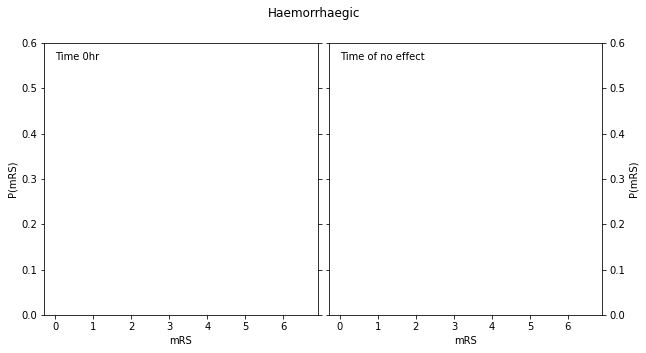

Sums of the plotted distributions (LHS, RHS):  0.0 0.0


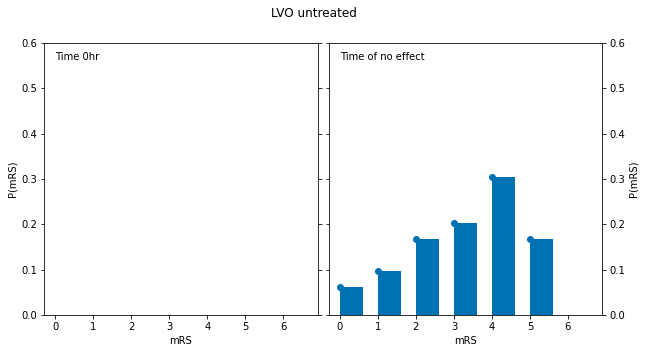

Sums of the plotted distributions (LHS, RHS):  0.0 1.0


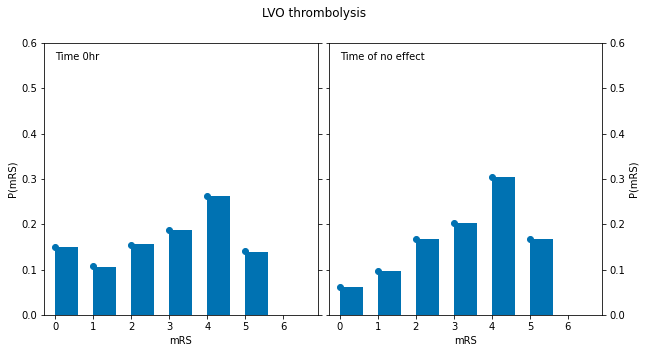

Sums of the plotted distributions (LHS, RHS):  1.0000000000000002 1.0


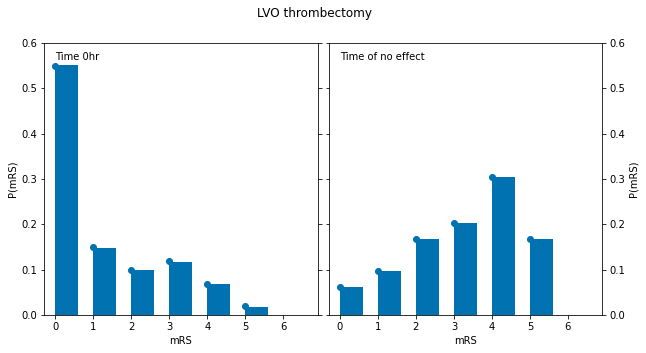

Sums of the plotted distributions (LHS, RHS):  1.00000001 1.0


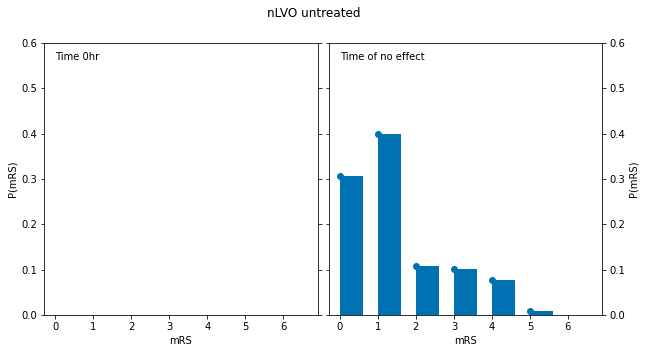

Sums of the plotted distributions (LHS, RHS):  0.0 1.0


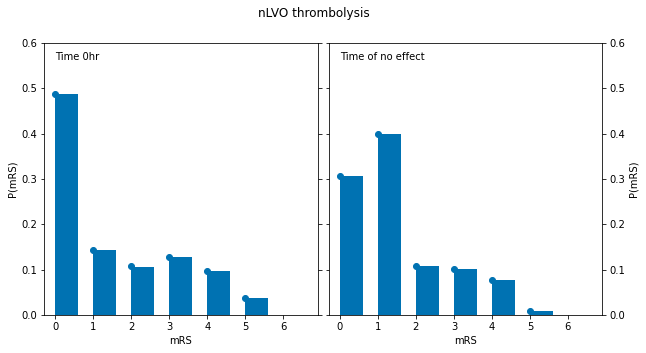

Sums of the plotted distributions (LHS, RHS):  1.0000000087298315 1.0


In [31]:
# Haemorrhaegic:
plot_two_hists([],[],title='Haemorrhaegic')

# LVO untreated:
plot_two_hists([], dist_F_LVO, title='LVO untreated')

# LVO thrombolysis only:
plot_two_hists(dist_0_LVOoly, dist_F_LVO, title='LVO thrombolysis')

# LVO thrombectomy with/out thrombolysis:
plot_two_hists(dist_0_pre, dist_F_LVO, title='LVO thrombectomy')

# nLVO untreated:
plot_two_hists([], dist_F_nLVO, title='nLVO untreated')

# nLVO thrombolysis:
plot_two_hists(dist_0_nLVOoly, dist_F_nLVO, title='nLVO thrombolysis')
